Milestone 2 | June 2023 | Group 15

This notebook is used to explore our top 3 SL models and to perform model evaluation.

In [1]:
# Predicting Match Results using Season To Date data (derived from main dataset containing only in-match data)
# Note: No in-match data is considered for this exercise

In [2]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def model_evaluation(y_test_values, y_predicted, clf_name, clf):
    print(f'Model Accuracy Score: {accuracy_score(y_test_values, y_predicted)}')
    print('='*42)
    print(f'{clf_name} Classification Report:\n {classification_report(y_test_values, y_predicted)}')
    print()
    print('='*42)    
    cm = confusion_matrix(y_test_values, y_predicted, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
    
    disp.plot()
#     plt.show()

In [4]:
from sklearn.model_selection import cross_val_score

def cross_val_score_calc(model, model_name, xtrain, ytrain, cv_int):
    print("=" * 24)
    scores = cross_val_score(model, xtrain, ytrain, cv=cv_int)
    print(f'{model_name} Five Cross Fold Validation Scores:\n {scores}')
    print(f'Mean: {round(np.mean(scores),3)}')
    print(f'Standard Deviation: {round(np.std(scores),3)}')
    print("=" * 24)

# 1. Load and prep the Season to Date (S2D) dataset* 
*Derived from the original dataset (containing only in-match data) to be part of a model

#### Loading our derived dataset with season to date metrics:

In [5]:
# df_s2d = pd.read_csv('sl_derived_dataset_2023_06.csv')
df_s2d = pd.read_csv("..\datasets\SL_outputs\sl_derived_dataset_2023_06.csv")
print(df_s2d.shape)
df_s2d.head(2)
# Note: it is normal to see NaN values at the start of each season

(8020, 125)


,date,season,home_team,away_team,FTR,H_home_goals_s2d,H_away_goals_s2d,H_total_goals_s2d,H_avg_home_goals_s2d,H_avg_away_goals_s2d,...,A_total_points_s2d,A_avg_home_points_s2d,A_avg_away_points_s2d,A_avg_points_s2d,A_home_points_against_s2d,A_away_points_against_s2d,A_total_points_against_s2d,A_avg_home_points_against_s2d,A_avg_away_points_against_s2d,A_avg_points_against_s2d
0,2000-08-19,1,Charlton,Man City,H,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-19,1,Chelsea,West Ham,H,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Trim the derived DF to remove, date, season number, as well as team names.
Rationale: they aren't necessary to predict a match's outcome based on the two team's season-to-date performance

In [6]:
df_s2d = df_s2d.iloc[:,4:]
df_s2d = df_s2d.dropna()
print(df_s2d.shape)
df_s2d.sample(4)

(7115, 121)


,FTR,H_home_goals_s2d,H_away_goals_s2d,H_total_goals_s2d,H_avg_home_goals_s2d,H_avg_away_goals_s2d,H_avg_goals_s2d,H_home_goals_against_s2d,H_away_goals_against_s2d,H_total_goals_against_s2d,...,A_total_points_s2d,A_avg_home_points_s2d,A_avg_away_points_s2d,A_avg_points_s2d,A_home_points_against_s2d,A_away_points_against_s2d,A_total_points_against_s2d,A_avg_home_points_against_s2d,A_avg_away_points_against_s2d,A_avg_points_against_s2d
5680,A,29.0,21.0,50.0,1.611111,1.166667,1.388889,17.0,22.0,39.0,...,42.0,1.000000,1.333333,1.166667,33.0,24.0,57.0,1.833333,1.333333,1.583333
7325,H,4.0,12.0,16.0,1.333333,4.000000,2.666667,5.0,3.0,8.0,...,5.0,0.333333,1.333333,0.833333,7.0,4.0,11.0,2.333333,1.333333,1.833333
7925,A,24.0,17.0,41.0,1.846154,1.133333,1.464286,20.0,19.0,39.0,...,51.0,2.133333,1.583333,1.888889,11.0,16.0,27.0,0.733333,1.333333,1.000000
3797,H,48.0,34.0,82.0,2.666667,1.789474,2.216216,12.0,16.0,28.0,...,47.0,1.421053,1.111111,1.270270,24.0,26.0,50.0,1.263158,1.444444,1.351351


_We see our target column 'FTR', along with all the other 120 derived features.  Now we will split the dataset into X and y values._

In [7]:
print(df_s2d.columns)

Index(['FTR', 'H_home_goals_s2d', 'H_away_goals_s2d', 'H_total_goals_s2d',
       'H_avg_home_goals_s2d', 'H_avg_away_goals_s2d', 'H_avg_goals_s2d',
       'H_home_goals_against_s2d', 'H_away_goals_against_s2d',
       'H_total_goals_against_s2d',
       ...
       'A_total_points_s2d', 'A_avg_home_points_s2d', 'A_avg_away_points_s2d',
       'A_avg_points_s2d', 'A_home_points_against_s2d',
       'A_away_points_against_s2d', 'A_total_points_against_s2d',
       'A_avg_home_points_against_s2d', 'A_avg_away_points_against_s2d',
       'A_avg_points_against_s2d'],
      dtype='object', length=121)


In [8]:
### Mark the independent and independent features
X, y = df_s2d.iloc[:, 1:], df_s2d.iloc[:, 0]

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
# print(f'original y values: {y}')


### Encode the target column 'y' to replace categorical values of H, A, and D into numerical values
enc = LabelEncoder()
y = enc.fit_transform(y)
integer_mapping = {l: i for i, l in enumerate(enc.classes_)}
print(f'Target variable "FTR" encoding mapping: {integer_mapping}')

X shape: (7115, 120)
y shape: (7115,)
Target variable "FTR" encoding mapping: {'A': 0, 'D': 1, 'H': 2}


### 1B.  Feature Selection:  Trimming down the Features to use in the models

In [9]:
selector = SelectKBest(k=18)

#fit_transform returns the data after selecting the best features
X_best = selector.fit_transform(X, y)

# get_support is a method of SelectKBest class
cols_idxs = selector.get_support(indices=True)
top_features_df = X.iloc[:,cols_idxs]
top_features_df

,H_avg_goals_s2d,H_avg_shots_s2d,H_avg_shots_against_s2d,H_avg_points_s2d,H_avg_points_against_s2d,A_avg_home_goals_s2d,A_avg_goals_s2d,A_avg_home_shots_s2d,A_avg_away_shots_s2d,A_avg_shots_s2d,A_avg_away_shots_against_s2d,A_avg_shots_against_s2d,A_avg_corners_against_s2d,A_avg_home_points_s2d,A_avg_away_points_s2d,A_avg_points_s2d,A_avg_away_points_against_s2d,A_avg_points_against_s2d
39,0.500000,7.250000,16.000000,1.000000,1.750000,3.500000,2.250000,17.500000,13.500000,15.500000,10.000000,8.500000,5.750000,3.000000,0.500000,1.750000,2.000000,1.000000
42,0.750000,8.500000,9.250000,2.000000,0.500000,2.000000,1.750000,13.000000,12.000000,12.500000,7.000000,7.500000,5.250000,0.500000,1.000000,0.750000,1.000000,1.500000
43,1.750000,10.750000,10.750000,1.750000,1.000000,2.500000,1.750000,14.500000,8.000000,11.250000,11.500000,10.250000,5.750000,1.500000,1.500000,1.500000,1.500000,1.500000
44,2.750000,15.750000,11.250000,2.000000,0.500000,1.000000,1.000000,12.500000,9.000000,10.750000,14.500000,14.750000,8.500000,2.000000,0.000000,1.000000,3.000000,1.750000
45,2.000000,12.000000,10.500000,1.250000,1.250000,2.500000,1.750000,12.500000,11.500000,12.000000,14.000000,10.750000,5.000000,2.000000,0.000000,1.000000,3.000000,1.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8015,1.324324,10.972973,11.702703,1.216216,1.378378,1.684211,1.540541,14.684211,12.166667,13.459459,14.833333,13.648649,5.567568,1.842105,1.277778,1.567568,1.444444,1.162162
8016,1.567568,11.432432,14.891892,1.324324,1.405405,1.210526,1.135135,12.421053,13.277778,12.837838,12.888889,13.108108,5.243243,1.315789,0.833333,1.081081,1.833333,1.567568
8017,2.459459,18.945946,7.810811,2.405405,0.378378,1.052632,1.000000,11.736842,9.555556,10.675676,14.277778,13.027027,5.378378,1.263158,1.500000,1.378378,1.333333,1.459459
8018,2.594595,18.675676,6.297297,2.432432,0.405405,1.526316,1.351351,12.368421,11.944444,12.162162,12.666667,12.243243,5.648649,1.210526,1.222222,1.216216,1.722222,1.621622


In [10]:
top_features_df.columns

Index(['H_avg_goals_s2d', 'H_avg_shots_s2d', 'H_avg_shots_against_s2d',
       'H_avg_points_s2d', 'H_avg_points_against_s2d', 'A_avg_home_goals_s2d',
       'A_avg_goals_s2d', 'A_avg_home_shots_s2d', 'A_avg_away_shots_s2d',
       'A_avg_shots_s2d', 'A_avg_away_shots_against_s2d',
       'A_avg_shots_against_s2d', 'A_avg_corners_against_s2d',
       'A_avg_home_points_s2d', 'A_avg_away_points_s2d', 'A_avg_points_s2d',
       'A_avg_away_points_against_s2d', 'A_avg_points_against_s2d'],
      dtype='object')

### 1C. Split train/test data and standardize feature values

In [11]:
#### Split our data for training and testing  

X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.35, stratify=y, random_state=0)


# Scale the independent Features for standardization
sc = StandardScaler()
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

### 1D.  Dummy Classifier as a reference point

Encoding y mapping: {'A': 0, 'D': 1, 'H': 2}
Model Accuracy Score: 0.3500602167804095
Dummy Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.26      0.27       718
           1       0.26      0.26      0.26       625
           2       0.45      0.45      0.45      1148

    accuracy                           0.35      2491
   macro avg       0.33      0.33      0.33      2491
weighted avg       0.35      0.35      0.35      2491




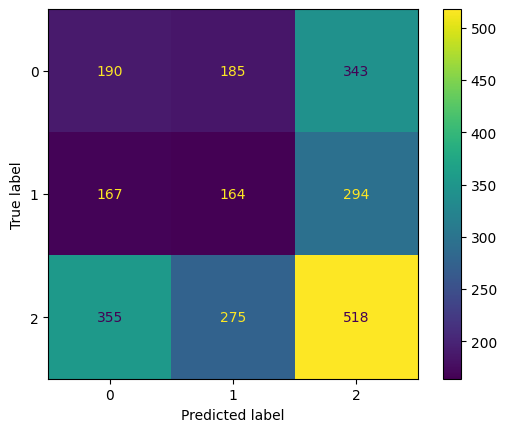

In [12]:
model_name = "Dummy"
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)


print(f'Encoding y mapping: {integer_mapping}')
model_evaluation(y_test, dummy_pred, model_name, dummy_clf)

# 2. Model Creation / evaluation

### 2a. Probabilistic model: Logistic Regression 

Encoding y mapping: {'A': 0, 'D': 1, 'H': 2}
Model Accuracy Score: 0.5327177840224809
LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51       718
           1       0.50      0.00      0.00       625
           2       0.54      0.84      0.66      1148

    accuracy                           0.53      2491
   macro avg       0.52      0.45      0.39      2491
weighted avg       0.52      0.53      0.45      2491




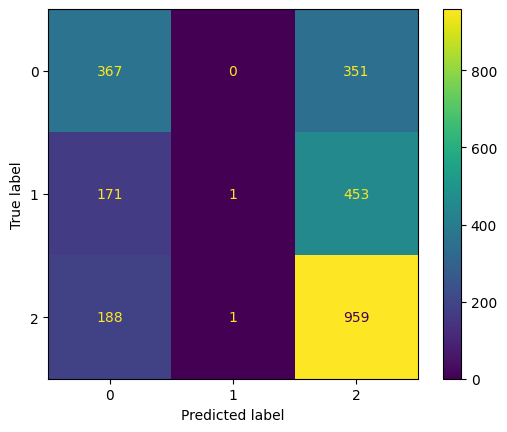

In [13]:
# Logistic Regression Classifier
model_name = 'LogisticRegression'
log_reg_clf = LogisticRegression(solver='liblinear', random_state=0, 
                                 max_iter=1000).fit(X_train, y_train)
Y_pred = log_reg_clf.predict(X_test)

model = log_reg_clf

print(f'Encoding y mapping: {integer_mapping}')
model_evaluation(y_test, Y_pred, model_name, model)

In [14]:
cross_val_score_calc(model, model_name, X_train, y_train, cv_int=5)

LogisticRegression Five Cross Fold Validation Scores:
 [0.53297297 0.52108108 0.50918919 0.53945946 0.53354978]
Mean: 0.527
Standard Deviation: 0.011


#### Feature Importance Analysis for Logistic Regression Model

In [15]:
# Get the feature names from the DataFrame, assuming they're in the same order as the features in the model
feature_names = top_features_df.columns

# Get the coefficients from the logistic regression model
coefficients = log_reg_clf.coef_[0]

# Create a DataFrame with the feature names and coefficients
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by the absolute value of the coefficient
feature_importance_df = feature_importance_df.reindex(
    feature_importance_df.Coefficient.abs().sort_values(ascending=False).index
)

feature_importance_df.head(10)

,Feature,Coefficient
15,A_avg_points_s2d,0.372388
3,H_avg_points_s2d,-0.290295
1,H_avg_shots_s2d,-0.259112
12,A_avg_corners_against_s2d,-0.202801
2,H_avg_shots_against_s2d,0.164847
9,A_avg_shots_s2d,0.134019
10,A_avg_away_shots_against_s2d,-0.106133
8,A_avg_away_shots_s2d,0.097103
7,A_avg_home_shots_s2d,-0.050031
5,A_avg_home_goals_s2d,-0.040389


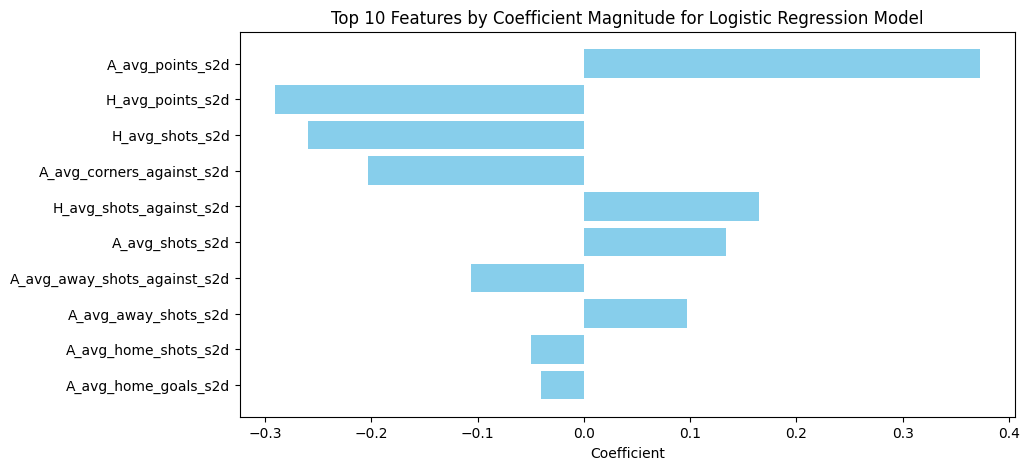

In [16]:
# Select the top 10 features
top_features = feature_importance_df.iloc[:10]

plt.figure(figsize=(10, 5))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Top 10 Features by Coefficient Magnitude for Logistic Regression Model')
plt.gca().invert_yaxis()
plt.show()

#### Sensitivity Analysis for Logistic Regression Model

Model Accuracy Score: 0.5323163388197512
LogisticRegression_with_C_0,5 Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.51       718
           1       0.50      0.00      0.00       625
           2       0.54      0.84      0.66      1148

    accuracy                           0.53      2491
   macro avg       0.52      0.45      0.39      2491
weighted avg       0.52      0.53      0.45      2491




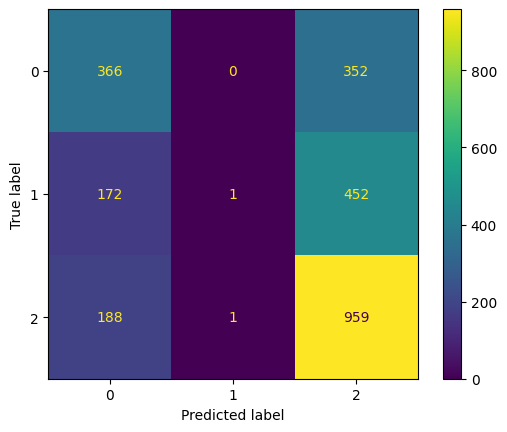

In [17]:
# Setting the parameter C (regularization coefficient) to 0.5.
clf = LogisticRegression(solver='liblinear', C=0.5, random_state=0, max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# evaluate model performance
model_evaluation(y_test, y_pred, f'{model_name}_with_C_0,5', model)

Model Accuracy Score: 0.5327177840224809
LogisticRegression_with_random_state_5 Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51       718
           1       0.50      0.00      0.00       625
           2       0.54      0.84      0.66      1148

    accuracy                           0.53      2491
   macro avg       0.52      0.45      0.39      2491
weighted avg       0.52      0.53      0.45      2491




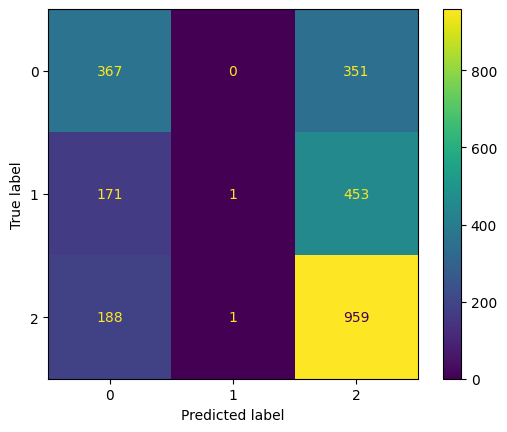

In [18]:
# change random_state parameter
clf2 = LogisticRegression(solver='liblinear', random_state=5, max_iter=1000)
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)

# evaluate model performance
model_evaluation(y_test, y_pred2, f'{model_name}_with_random_state_5', model)

Model Accuracy Score: 0.5335206744279406
LogisticRegression_with_solver_sag Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51       718
           1       0.50      0.00      0.00       625
           2       0.54      0.84      0.66      1148

    accuracy                           0.53      2491
   macro avg       0.52      0.45      0.39      2491
weighted avg       0.52      0.53      0.45      2491




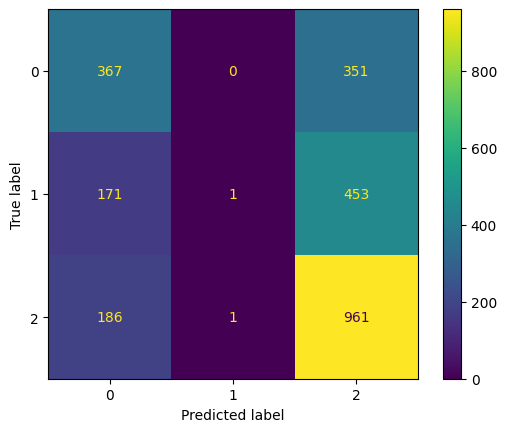

In [19]:
# change solver parameter
clf3 = LogisticRegression(solver='sag', random_state=0, max_iter=1000)
clf3.fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)

# evaluate model performance
model_evaluation(y_test, y_pred3, f'{model_name}_with_solver_sag', model)

### 2b. Non probabilistic model: SVM

Encoding y mapping: {'A': 0, 'D': 1, 'H': 2}
Model Accuracy Score: 0.537133681252509
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.48      0.50       718
           1       0.20      0.00      0.00       625
           2       0.54      0.86      0.67      1148

    accuracy                           0.54      2491
   macro avg       0.42      0.45      0.39      2491
weighted avg       0.45      0.54      0.45      2491




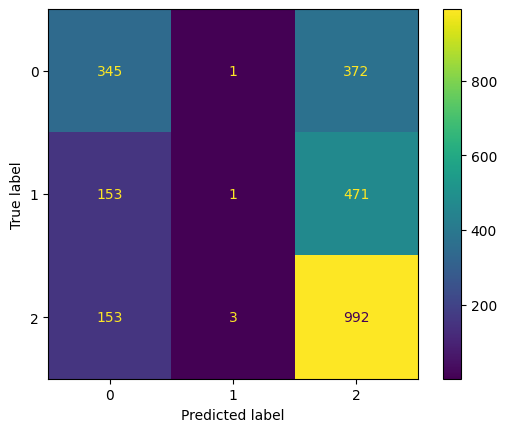

In [20]:
model_name = 'SVM'
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
Y_pred = svm_clf.predict(X_test)
model = svm_clf 

print(f'Encoding y mapping: {integer_mapping}')
model_evaluation(y_test, Y_pred, model_name, model)

In [21]:
cross_val_score_calc(model, model_name, X_train, y_train, cv_int=5)

SVM Five Cross Fold Validation Scores:
 [0.52324324 0.51351351 0.51027027 0.53621622 0.53138528]
Mean: 0.523
Standard Deviation: 0.01


### 2c. Tree based Model: Random Forest

Encoding y mapping: {'A': 0, 'D': 1, 'H': 2}
Model Accuracy Score: 0.5114411882778
RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.49      0.49       718
           1       0.27      0.09      0.13       625
           2       0.55      0.75      0.64      1148

    accuracy                           0.51      2491
   macro avg       0.44      0.44      0.42      2491
weighted avg       0.46      0.51      0.47      2491




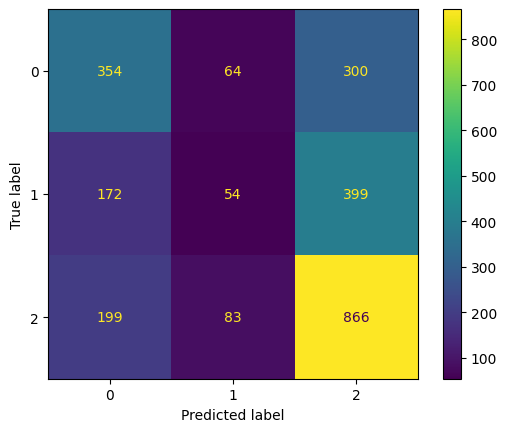

In [22]:
model_name = 'RandomForest'
rf_clf = RandomForestClassifier(max_depth=20, random_state=0)
rf_clf.fit(X_train, y_train)
Y_pred = rf_clf.predict(X_test)
model = rf_clf 
print(f'Encoding y mapping: {integer_mapping}')
model_evaluation(y_test, Y_pred, model_name, model)

In [23]:
cross_val_score_calc(model, model_name, X_train, y_train, cv_int=5)

RandomForest Five Cross Fold Validation Scores:
 [0.50918919 0.50162162 0.50378378 0.51891892 0.50974026]
Mean: 0.509
Standard Deviation: 0.006


Random Forest Notes: 
- low tree depth hyper param is almost entirely innacurate when classifying Draws (label 1).
- Label 2 (Home wins) repeatedly has the highest F1 score.